In [1]:
import numpy as np
from scipy.signal import ricker
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# Energy in a spring/mass system
This notebook sets up and calculates the energy in a N-mass/N+1-spring system and looks at how that energy converts between potential and kinetic energy and how that energy varies and changes between different springs and masses.

In [2]:
#Setup the physical parameters

K=0.05
L=1.
M=1.

c=np.sqrt(K*L**2/M)

N=120.

tmax=np.pi
dt=0.001

xmax=15.
dx=0.01

eps=0.001

t=np.arange(0,tmax,dt)
x=np.arange(0,xmax,dx)

nt=np.size(t)
nx=np.size(x)

We will use a ricker wavelet and just translate it for the wave propagation.  This sets up the ricker wavelet.

(6284,)
(6284,)


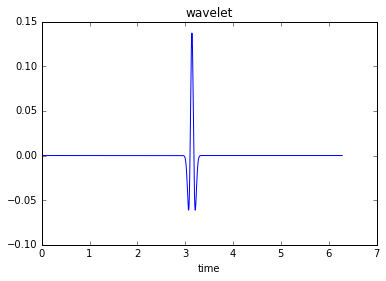

In [3]:
f=ricker(2*nt,40.)
t2=np.linspace(0,2.*tmax-dt,2*nt)
print(np.shape(t2))
print(np.shape(f))
plt.plot(t2,f)
plt.title('wavelet')
plt.xlabel('time')
plt.show()
#plt.xlim([40,60])

Setup some functions to compute the kinetic and potential energy as well as to do the translation for the wave solution.

In [4]:
def KineticE(m,u,dt):
    return 0.5*m*((u[2:]-u[:-2])/2./dt)**2.
    #return 0.5*m*(np.diff(u)/dt)**2.

In [5]:
def PotentialE(k,u):
    return 0.5*k*u**2.

# Now let's look at a simple harmonic oscillator
In this case we have a single mass and spring and the system satisfies 
$$
m \frac{\partial^2 u(x,t)}{\partial t^2} = -kx \, ,
$$
which is solved with
$$
u(x,t) = A \cos (\omega t + \phi)
$$
where $\omega=\sqrt{k/m}$.

First we compute the frequency and displacement using the exact solution above.

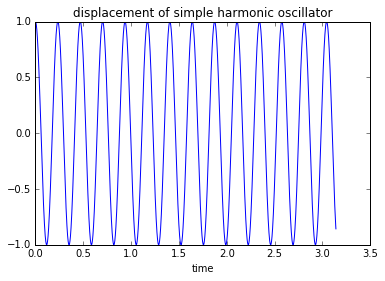

In [6]:

omega=np.sqrt(K*N/(M/N))
u_osc=np.cos(omega*t)
plt.plot(t,u_osc)
plt.title('displacement of simple harmonic oscillator')
plt.xlabel('time')
#plt.xlim([0,20])
plt.show()

Now compute the energies, and check that it is conserved.  Now we see the oscillation between kinetic and potential energy.

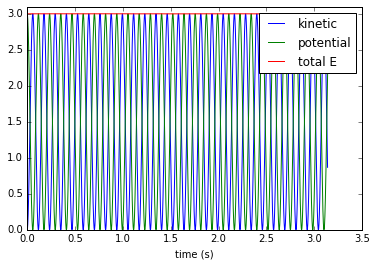

In [7]:
u_osc_kE=KineticE(M/N,u_osc,dt)
u_osc_pE=PotentialE(K*N,u_osc)
fig1=plt.figure()
plt.plot(t[1:-1],u_osc_kE,label='kinetic')
plt.plot(t,u_osc_pE,label='potential')
plt.plot(t[1:-1],u_osc_pE[1:-1]+u_osc_kE,label='total E')
plt.xlabel('time (s)')
#plt.xlim([0,20])
plt.ylim([0,3.1])
plt.legend()
plt.show()

# Now setup oscillator as a PDE solve
Writing the PDE in discrete form gives:
$$
\frac{u(t+dt)-2u(t)+u(t-dt)}{dt^2}=-\frac{k}{m} u(t)
$$
solving we have that
$$
u(t+dt)=-\frac{k}{m} dt^2 u(t) + 2u(t) - u(t-dt)
$$
We use this just to check that our numerical solutions, which we will setup in more complicated cases later are working.

In [8]:
def Oscillator(k,m,nt,dt,u0):
    u=np.zeros_like(t)
    u[0]=u0
    u[-1]=u0
    
    for ii in range(0,nt-1):
        u[ii+1]=-k/m*dt**2*u[ii]+2*u[ii]-u[ii-1]
        
    return u

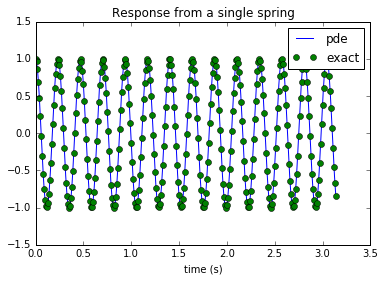

In [9]:
u_osc_pde=Oscillator(K*N,M/N,nt,dt,1.0)
plt.plot(t,u_osc_pde,label='pde')
plt.plot(t[0::10],u_osc[0::10],'o',label='exact')
plt.legend()
plt.xlabel('time (s)')
plt.title('Response from a single spring')
plt.show()
#plt.xlim([0,10])

In [10]:
#Check that the code is working, should be small and should decrease as dt is decreased (like 1/dt^2)
print(np.sum(np.sqrt((u_osc_pde-u_osc)**2.0))/np.sum(np.sqrt(u_osc**2.0)))

0.0147839294619


# Now compute the result for a coupled system of two masses and 3 springs
We are going to assume that we have 3 springs, two of which are attached to immovable walls, with one in between each pair of springs, so 2 masses (i.e. it is wall-spring-mass-spring-mass-spring-wall).  We will assume that the two masses have the same mass and the three springs have the same spring constants.  We then setup a system of equations for the displacement of the two masses ($u_1$ and $u_2$).  There is a nice picture of this here: http://farside.ph.utexas.edu/teaching/315/Waves/node18.html

So now
$$
m \frac{\partial^2 u_1(t)}{\partial_t^2} = -k u_1(t) + k (u_2(t) -u_1(t))\\
m \frac{\partial^2 u_2(t)}{\partial_t^2} = -k (u_2(t)-u_1(t)) - k u_2(t)
$$
writing this out as a coupled system gives
$$
m \frac{\partial^2 }{\partial_t^2} 
\begin{bmatrix} u_1\\u_2 \end{bmatrix} = 
k\begin{bmatrix}
-2&1\\1&-2
\end{bmatrix}
\begin{bmatrix} u_1\\u_2 \end{bmatrix}
$$
and as finite-difference, we have
$$
\begin{bmatrix} u_1\\u_2 \end{bmatrix}(it+1)
-2\begin{bmatrix} u_1\\u_2 \end{bmatrix}(it)
+\begin{bmatrix} u_1\\u_2 \end{bmatrix}(it-1)
=dt^2 \frac{k}{m} \begin{bmatrix}
-2&1\\1&-2
\end{bmatrix}
\begin{bmatrix} u_1\\u_2 \end{bmatrix}(it)
$$

In [11]:
def twoSprings(k,m,dt,nt,u10,u20):
    u1=np.zeros([nt])
    u2=np.zeros([nt])
    
    u1[0]=u10
    u1[-1]=u10
    u2[0]=u20
    u2[-1]=u20
    
    for ii in range(0,nt-1):
        u1[ii+1]=-k/m*dt**2*(2.*u1[ii]-u2[ii])+2.*u1[ii]-u1[ii-1]
        u2[ii+1]=-k/m*dt**2*(2.*u2[ii]-u1[ii])+2.*u2[ii]-u2[ii-1]
        
    return u1,u2
    

Now we compute the displacements, note that there are 3 displacements, but only two masses so there are 3 contributers to the potential energy from the 3 springs, but only 2 contributions to the kinetic energy from the two masses.

In [12]:
u10=1.0
u20=0.0
u1,u2=twoSprings(K*N,M/N,dt,nt,u10,u20)
u3=u2-u1

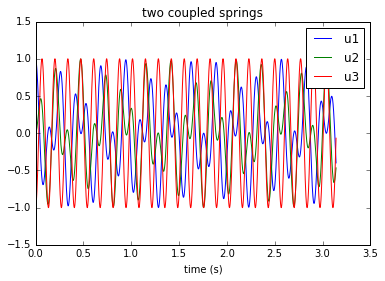

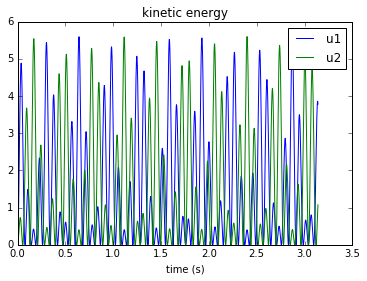

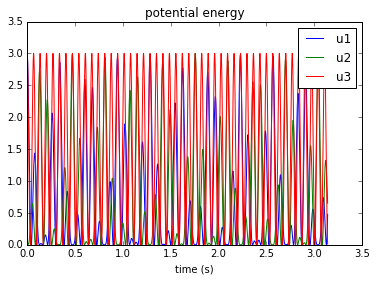

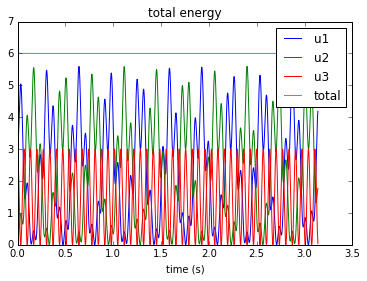

In [13]:
plt.plot(t,u1,label='u1')
plt.plot(t,u2,label='u2')
plt.plot(t,u3,label='u3')
plt.legend()
plt.xlabel('time (s)')
plt.title('two coupled springs')
#plt.xlim([0,.2])

u1_kE=KineticE(M/N,u1,dt)
u1_pE=PotentialE(K*N,u1)
u2_kE=KineticE(M/N,u2,dt)
u2_pE=PotentialE(K*N,u2)
u3_kE=KineticE(M/N,u3,dt)
u3_pE=PotentialE(K*N,u3)

plt.figure()
plt.title('kinetic energy')
plt.xlabel('time (s)')
plt.plot(t[1:-1],u1_kE,label='u1')
plt.plot(t[1:-1],u2_kE,label='u2')
plt.legend()

plt.figure()
plt.title('potential energy')
plt.xlabel('time (s)')
plt.plot(t,u1_pE,label='u1')
plt.plot(t,u2_pE,label='u2')
plt.plot(t,u3_pE,label='u3')
plt.legend()

E_tot=u1_pE[1:-1]+u2_pE[1:-1]+u3_pE[1:-1]+u1_kE+u2_kE#+u3_kE
E_tot1=u1_pE[1:-1]+u2_pE[1:-1]+u1_kE+u2_kE

plt.figure()
plt.title('total energy')
plt.xlabel('time (s)')
plt.plot(t[1:-1],u1_pE[1:-1]+u1_kE,label='u1')
plt.plot(t[1:-1],u2_pE[1:-1]+u2_kE,label='u2')
plt.plot(t[1:-1],u3_pE[1:-1],label='u3')
plt.plot(t[1:-1],E_tot,label='total')
plt.legend()
plt.show()

# Now let's progress to N masses and N+1 springs
The idea is to take a spring/mass system and send a pulse from one end of that system.  Then we can record this pulse at some mass within the system and then we try to apply a force to the other end of the system so that the mass will stop, and eventually the whole system will come to rest. 

## First let's write a routine for n springs instead of just 3
So now our coupled system of equations becomes (with the two end points being different than all the pairs in the middle).
$$
m \frac{\partial^2 u_1(t)}{\partial_t^2} = -k u_1(t) + k (u_2(t) -u_1(t)) = k[u_2(t)-2u_1(t)]\\
m \frac{\partial^2 u_j(t)}{\partial_t^2} = -k (u_j(t)-u_{j-1}) + k(u_{j+1}-u_{j})=k[u_{j+1}(t)-2u_j(t)+u_{j-1}(t)]\\
m \frac{\partial^2 u_n(t)}{\partial_t^2} = -k (u_{n}(t)-u_{n-1}(t)) - k u_n(t) = k[u_{n-1}(t)-2u_n(t)]
$$


In [14]:
def manySprings(k,m,dt,nt,u10,un0,nmasses,L,h,force_fn):
    u=np.zeros([nt,nmasses])
    
    u[0,0]=u10
    u[-1,0]=u10  #Note that setting this sets the derivative at 0 to be 0, but the actual final value will be reset in the loop below
#    u[0,-1]=un0
#    u[-1,-1]=un0
    
    
    for ii in range(0,nt-1):
        u[ii+1,0]=k/m*(dt*L/h)**2*(u[ii,1]-2.*u[ii,0])+2*u[ii,0]-u[ii-1,0]+force_fn[ii+1,0]*dt**2
        u[ii+1,1:-1]=k/m*(dt*L/h)**2*(u[ii,2:]-2.*u[ii,1:-1]+u[ii,:-2])+2.*u[ii,1:-1]-u[ii-1,1:-1]+force_fn[ii+1,1:-1]*dt**2
        u[ii+1,-1]=k/m*(dt*L/h)**2*(u[ii,-2]-2.*u[ii,-1])+2*u[ii,-1]-u[ii-1,-1]+force_fn[ii+1,-1]*dt**2
        
    return u
        #u2[ii+1]=-k/m*dt**2*(2.*u2[ii]-u1[ii])+2.*u2[ii]-u2[ii-1]
  

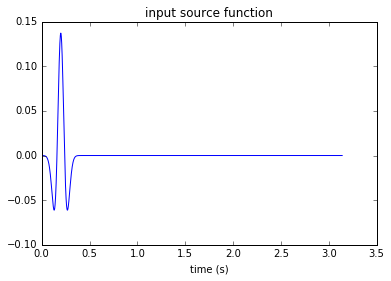

In [15]:
#Now we setup our input source function 
nmasses=np.int(N)
force_fn=np.zeros([nt,nmasses])
force_fn[:,0]=f[nt-200:2*nt-200]
plt.plot(t,force_fn[:,0])
plt.title('input source function')
plt.xlabel('time (s)')
#plt.xlim([0,200])
plt.show()

In [16]:
# We need to reset our K-value as we now have many masses and we want to see a propagating wave now
K=1.0

In [17]:
#And run this to get the displacement of all of the masses, with the input force shown above
u_masses=manySprings(K,M,dt,nt,0.0,0.0,nmasses,L,L/N,force_fn)

#Note that the displacement in any spring is the difference of the displacement in the two
#adjacent masses, which is what we setup here, except for the springs on the edges whose displacement
#is just that of the closest mass, since we assume that the boundaries are fixed
u_springs=np.zeros([nt,nmasses+1])
u_springs[:,0]=u_masses[:,0]
u_springs[:,1:-1]=u_masses[:,1:]-u_masses[:,0:-1]
u_springs[:,-1]=u_masses[:,-1]


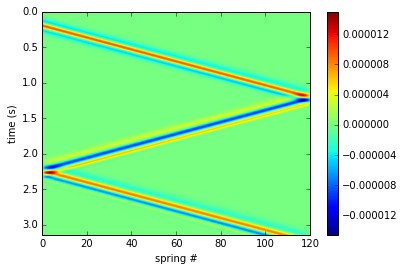

In [18]:
plt.imshow(u_masses,aspect='auto',extent=[0,N,t[nt-1],t[0]])
plt.xlabel('spring #')
plt.ylabel('time (s)')
plt.colorbar()
plt.show()

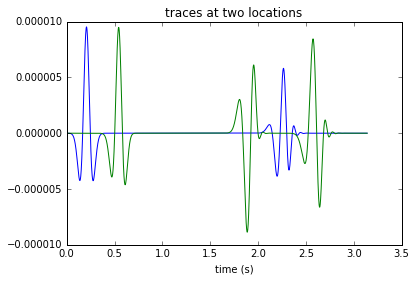

In [19]:
plt.plot(t,u_masses[:,0])
plt.plot(t,u_masses[:,40])
plt.xlabel('time (s)')
plt.title('traces at two locations')
plt.show()

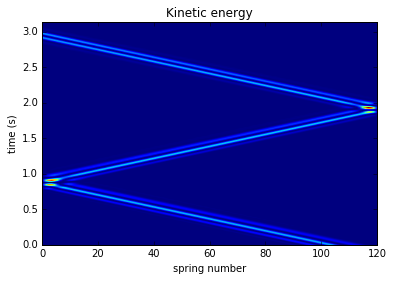

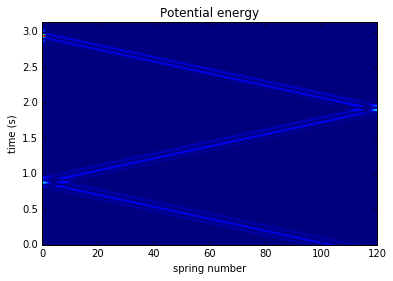

In [20]:
u_many_KE=KineticE(M/N,u_masses,dt)
u_many_PE=PotentialE(K*N,u_springs)
plt.figure()
plt.imshow(u_many_KE,aspect='auto',extent=[0,N,0,t[nt-1]])
plt.xlabel('spring number')
plt.ylabel('time (s)')
plt.title('Kinetic energy')
plt.figure()
plt.imshow(u_many_PE,aspect='auto',extent=[0,N,0,t[nt-1]])
plt.title('Potential energy')
plt.xlabel('spring number')
plt.ylabel('time (s)')
plt.show()

In [21]:
total_KE=np.sum(u_many_KE,1)
total_PE=np.sum(u_many_PE[1:-1],1)
total_E=total_KE+total_PE

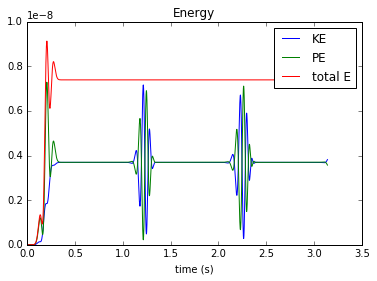

In [22]:
plt.title('Energy')
plt.xlabel('time (s)')
plt.plot(t[1:-1],total_KE,label='KE')
plt.plot(t[1:-1],total_PE,label='PE')
plt.plot(t[1:-1],total_E,label='total E')
plt.legend()
plt.show()

We see above that energy is conserved for our system and that we get something that looks reasonable, and like the solution of the 1D wave equation. 

# Now try to apply the IBCs to remove the reflection

What we are going to do, to make everything as simple as possible is to simply record the wavefield at mass number 60 and then rerun in a smaller domain.  In other words, we record the signal at mass number 60 and then make that into a wall to which we will apply a force computed from our recorded displacement.  This force should cancel the boundary reflection from a boundary at spring 60.

What we will compute is:
- the system without the IBC, (labelled force)
- the system with the IBC, but without the initial forcing function (labelled IBC)
- the system with both the IBC and the initial forcing function (labelled all); it is this last one where we should see the cancellation

To compute the input force for the right-hand-side to apply the IBC, we take the signal recorded at spring 60 from above, scale it by $N^2$ where $N$ is the number of springs in the model above (not sure why) and zero-out the signal from after the initial wave.  We then apply the resulting signal as a force on the right-hand side of the smaller domain.

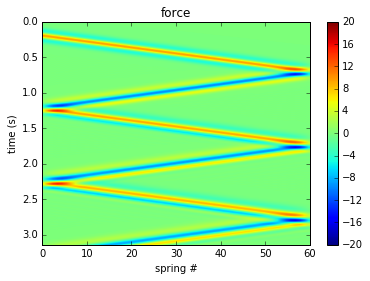

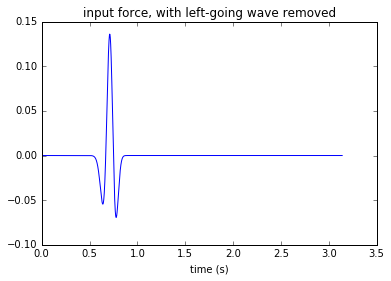

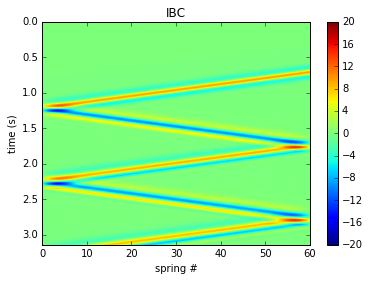

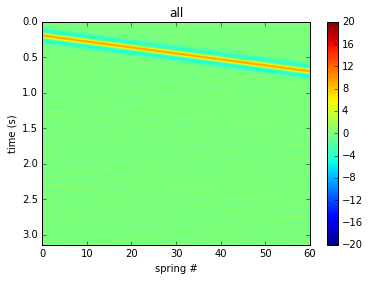

In [23]:
nmasses2=60

force2=np.zeros([nt,nmasses2])
force2[:,0]=force_fn[:,0]
u_masses2_f=manySprings(K,M,dt,nt,0.0,0.0,nmasses2,L,L/N,force2)
plt.figure()
plt.imshow(u_masses2_f*1e6,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('force')
plt.ylabel('time (s)')
plt.xlabel('spring #')
plt.clim([-20,20])
plt.colorbar()


force2=np.zeros([nt,nmasses2])
force2[:,nmasses2-1]=u_masses[:,nmasses2]*N**2.
force2[1400:,nmasses2-1]=0.
plt.figure()
plt.plot(t,force2[:,nmasses2-1])
plt.xlabel('time (s)')
plt.title('input force, with left-going wave removed')

u_masses2_IBC=manySprings(K,M,dt,nt,0.0,0.0,nmasses2,L,L/N,force2)
plt.figure()
plt.imshow(u_masses2_IBC*1e6,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('IBC')
plt.ylabel('time (s)')
plt.xlabel('spring #')
plt.clim([-20,20])
plt.colorbar()

force2[:,0]=force_fn[:,0]
u_masses2_all=manySprings(K,M,dt,nt,0.0,0.0,nmasses2,L,L/N,force2)
plt.figure()
plt.imshow(u_masses2_all*1e6,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('all')
plt.ylabel('time (s)')
plt.xlabel('spring #')
plt.clim([-20,20])
plt.colorbar()


plt.show()

In [24]:
#This is a little function to compute the displacements of the springs given the displacements of the masses
#so that we can later compute the energy, it's the same as what is done above for the 3 spring case, just generalized 
#and made into a function for convenience

def springs_from_masses(nt,nmasses,u_masses):
    u_springs=np.zeros([nt,nmasses+1])
    u_springs[:,0]=u_masses[:,0]
    u_springs[:,1:-1]=u_masses[:,1:]-u_masses[:,0:-1]
    u_springs[:,-1]=u_masses[:,-1]
    return u_springs


In [25]:
#This just does a bunch of computations and plotting to avoid writing out the same thing a bunch of times
def compute_and_plotE(nt,nmasses,K,N,M,dt,u_masses):
    u_springs=springs_from_masses(nt,nmasses,u_masses)
    uKE=KineticE(M/N,u_masses,dt)
    uPE=PotentialE(K*N,u_springs)
    total_KE=np.sum(uKE,1)
    total_PE=np.sum(uPE[1:-1],1)
    total_E=total_KE+total_PE
    
    plt.figure()
    plt.plot(t[1:-1],total_KE,label='kinetic E')
    plt.plot(t[1:-1],total_PE,label='potential E')
    plt.plot(t[1:-1],total_E,label='total E')
    plt.legend()
    
    return total_E,uKE,uPE


Now that we have computed the 3 wavefields we are interested in, we are going to look at the energies.  This is the total energy in the system in each case, split into kinetic and potential, but summed over all of the springs and masses.  We see that first, energy is still conserved, though we first put energy into the system from the force.  We then clearly remove energy with the IBC, which makes sense since it's cancelling out different waves.  This doesn't show us much about where that energy goes, however, so we look into that below.

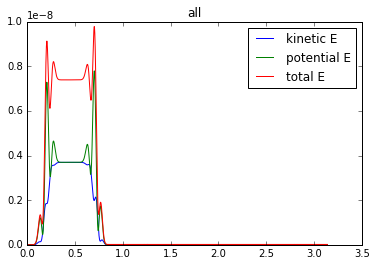

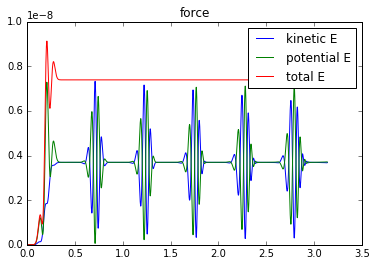

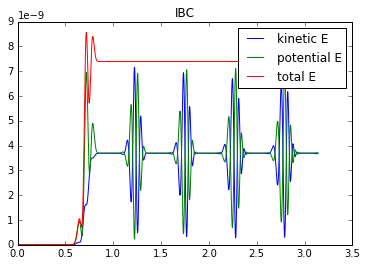

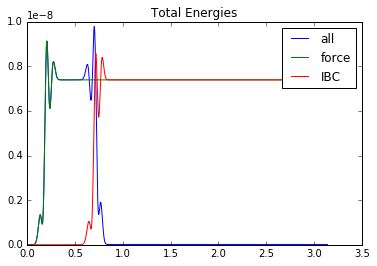

In [26]:

E_all,KE_all,PE_all=compute_and_plotE(nt,nmasses2,K,N,M,dt,u_masses2_all)
plt.title('all')
E_f,KE_f,PE_f=compute_and_plotE(nt,nmasses2,K,N,M,dt,u_masses2_f)
plt.title('force')
E_IBC,KE_IBC,PE_IBC=compute_and_plotE(nt,nmasses2,K,N,M,dt,u_masses2_IBC)
plt.title('IBC')

plt.figure()
plt.plot(t[1:-1],E_all,label='all')
plt.plot(t[1:-1],E_f,label='force')
plt.plot(t[1:-1],E_IBC,label='IBC')
plt.title('Total Energies')
plt.legend()

plt.show()


# Where does the energy go?

To try to answer this, we look at the energy in different springs and masses throughout the system.  What we find is that just about everything happens in the last mass/spring and it involves both energy conversion and energy input into that part of the system.

First, we look at a mass/spring in the middle or left, up to about spring number 50 (or 5/6 of the way across from left to right). We see that for the first pulse the 'all' and 'force' match, which makes sense as this is the pulse we are keeping. If we then look at a slightly later pulse (e.g. the second pulse that's reflected once off of the right boundary), then the 'all' and 'IBC' match because the 'IBC' is matching this pulse.  (Note that the PE is much smaller than the KE here.)

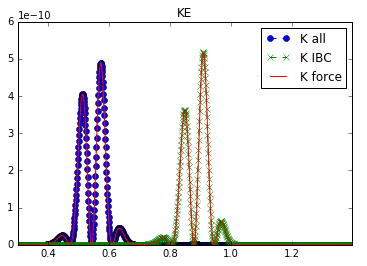

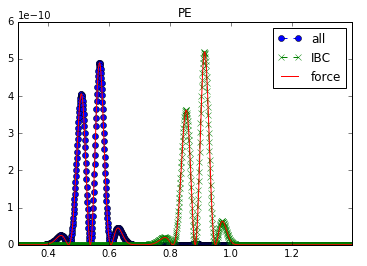

In [27]:
ind_to_plot=40
xlims=[0.3,1.4]
plt.figure()
plt.plot(t[1:-1],KE_all[:,ind_to_plot],'o--',label='K all')
plt.plot(t[1:-1],KE_IBC[:,ind_to_plot],'x--',label='K IBC')
plt.plot(t[1:-1],KE_f[:,ind_to_plot],label='K force')
plt.xlim(xlims)
plt.title('KE')
plt.legend()
plt.figure()
plt.plot(t,PE_all[:,ind_to_plot],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot],label='force')
plt.xlim(xlims)
plt.title('PE')
plt.legend()
plt.show()

Now if we look closer to the boundary, at spring 50 we see the pulses overlap around t=0.7 s, so now there is some mixing between the energies in all 3 cases.  Looking at the peak at 0.65 s we see that in the case with both the IBC and the force, there is some transfer from kinetic energy to potential energy, so there is more energy in the spring (potential energy increases) because the mass is slowing down (kinetic energy decreases).

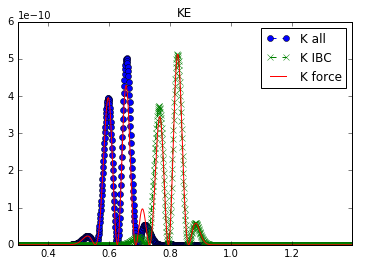

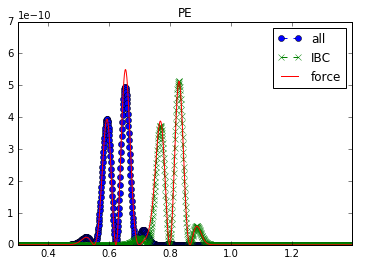

In [28]:
ind_to_plot=50
xlims=[0.3,1.4]
plt.figure()
plt.plot(t[1:-1],KE_all[:,ind_to_plot],'o--',label='K all')
plt.plot(t[1:-1],KE_IBC[:,ind_to_plot],'x--',label='K IBC')
plt.plot(t[1:-1],KE_f[:,ind_to_plot],label='K force')
plt.xlim(xlims)
plt.title('KE')
plt.legend()
plt.figure()
plt.plot(t,PE_all[:,ind_to_plot],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot],label='force')
plt.xlim(xlims)
plt.title('PE')
plt.legend()
plt.show()

Now if look even closer to the edge, we see this effect enhanced, i.e. there is a transfer from what had been kinetic energy with the force alone is now potential energy when we turn on the IBC.

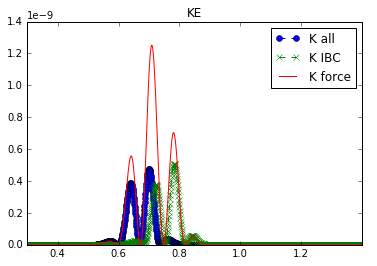

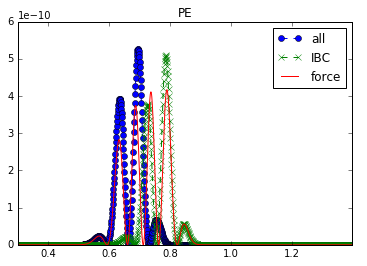

In [29]:
ind_to_plot=55
xlims=[0.3,1.4]
plt.figure()
plt.plot(t[1:-1],KE_all[:,ind_to_plot],'o--',label='K all')
plt.plot(t[1:-1],KE_IBC[:,ind_to_plot],'x--',label='K IBC')
plt.plot(t[1:-1],KE_f[:,ind_to_plot],label='K force')
plt.xlim(xlims)
plt.title('KE')
plt.legend()
plt.figure()
plt.plot(t,PE_all[:,ind_to_plot],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot],label='force')
plt.xlim(xlims)
plt.title('PE')
plt.legend()
plt.show()

This effect continues right up to the second-to-last spring/mass, but we can see that the kinetic energy is increasing for both the IBC alone and the IBC when both waves are sent simultaneously (all).  Above we had been plotting the potential energy in the spring to the left of the mass, and the one to the right wasn't much different.  As we get closer to the boundary the two springs begin to have different energies so we're now plotting both.  Below we see that the second-to-rightmost spring has a lot more potential energy in the 'force' case than in the 'all' case indicating that the IBC is removing potential energy.

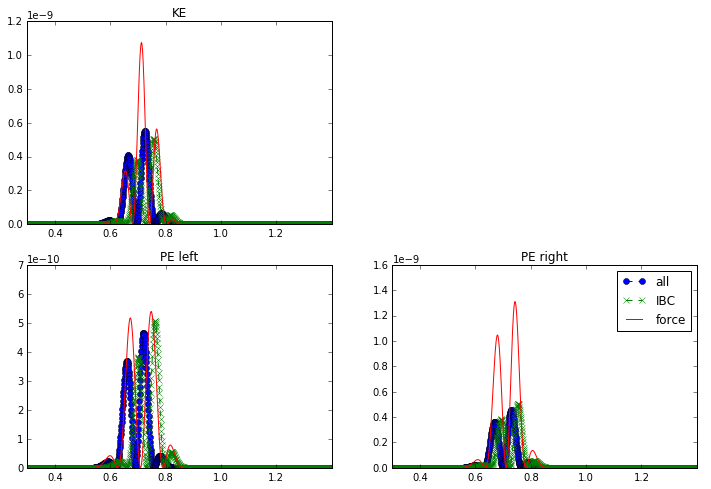

In [30]:
ind_to_plot=58
xlims=[0.3,1.4]
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(t[1:-1],KE_all[:,ind_to_plot],'o--',label='K all')
plt.plot(t[1:-1],KE_IBC[:,ind_to_plot],'x--',label='K IBC')
plt.plot(t[1:-1],KE_f[:,ind_to_plot],label='K force')
plt.xlim(xlims)
plt.title('KE')
plt.subplot(223)
plt.plot(t,PE_all[:,ind_to_plot],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot],label='force')
plt.xlim(xlims)
plt.title('PE left')
plt.subplot(224)
plt.plot(t,PE_all[:,ind_to_plot+1],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot+1],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot+1],label='force')
plt.xlim(xlims)
plt.title('PE right')
plt.legend()
plt.show()

Now if we look at the very last spring/mass, we see a bit of a change as we have more kinetic energy in the 'all' and 'IBC' than we do with the force by itself.  I think that this makes sense because without the IBCs when the wave hits the wall it basically stops, pushing all of its energy into potential energy.  (Note that now PE>KE.) But when the IBC is on there is comparitavely more energy in the spring on the right than in the spring on the left.  Note also that the last mass is moving faster with the IBC on than it does with the IBC off, which is not true for earlier masses (masses that are more to the left).

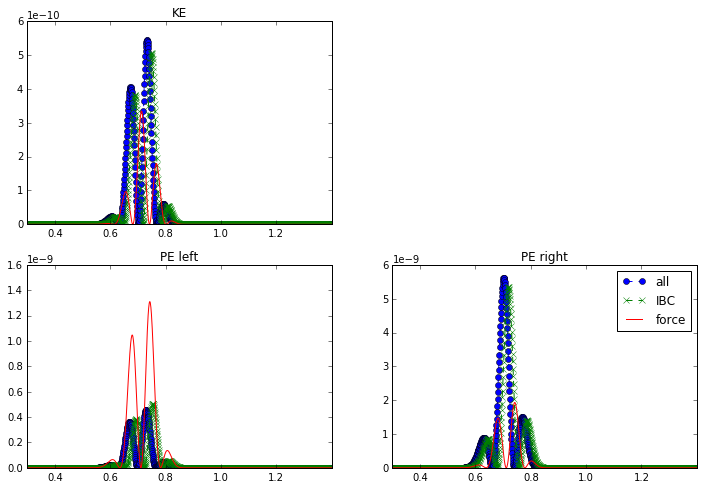

In [31]:
ind_to_plot=59
xlims=[0.3,1.4]
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(t[1:-1],KE_all[:,ind_to_plot],'o--',label='K all')
plt.plot(t[1:-1],KE_IBC[:,ind_to_plot],'x--',label='K IBC')
plt.plot(t[1:-1],KE_f[:,ind_to_plot],label='K force')
plt.xlim(xlims)
plt.title('KE')
plt.subplot(223)
plt.plot(t,PE_all[:,ind_to_plot],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot],label='force')
plt.xlim(xlims)
plt.title('PE left')
plt.subplot(224)
plt.plot(t,PE_all[:,ind_to_plot+1],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot+1],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot+1],label='force')
plt.xlim(xlims)
plt.title('PE right')
plt.legend()
plt.show()

If we look at the potential energy of the last 3 springs on the same scale, we see that there's a huge spike in the potential energy at the boundary when we turn on the IBC, which makes sense as we are applying a force to the last mass (which is connected to the boundary by the last spring, i.e. it is between the springs labelled as mid and right on the plots below).  What we've seen here is that force dissipates really quickly and it increases the kinetic energy of the closest mass

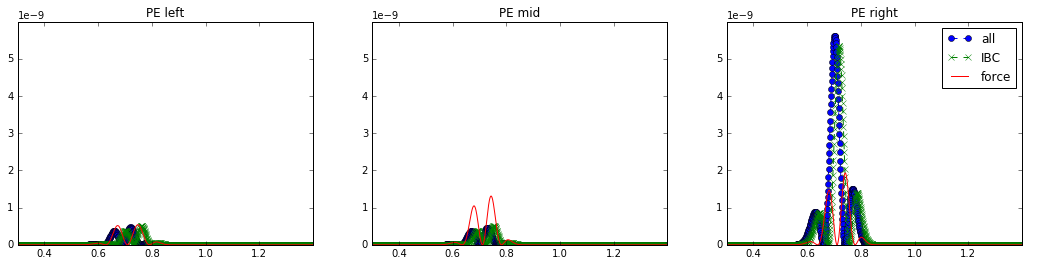

In [32]:
ind_to_plot=59
xlims=[0.3,1.4]
ylims=[0,6e-9]
plt.figure(figsize=[18,4])
plt.subplot(131)
plt.plot(t,PE_all[:,ind_to_plot-1],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot-1],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot-1],label='force')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('PE left')
plt.subplot(132)
plt.plot(t,PE_all[:,ind_to_plot],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot],label='force')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('PE mid')
plt.subplot(133)
plt.plot(t,PE_all[:,ind_to_plot+1],'o--',label='all')
plt.plot(t,PE_IBC[:,ind_to_plot+1],'x--',label='IBC')
plt.plot(t,PE_f[:,ind_to_plot+1],label='force')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('PE right')
plt.legend()
plt.show()

Now, just for fun let's look at the energy as a function of position and time.  (Note that the total energy in this case is somewhat poorly defined since all I'm doing is adding the kinetic energy of one mass to the potential energy of the spring to its left and ignoring the very last spring (so that I can add the two matrices).)  This isn't that interesting, mostly showing that the excitement is at the ends.

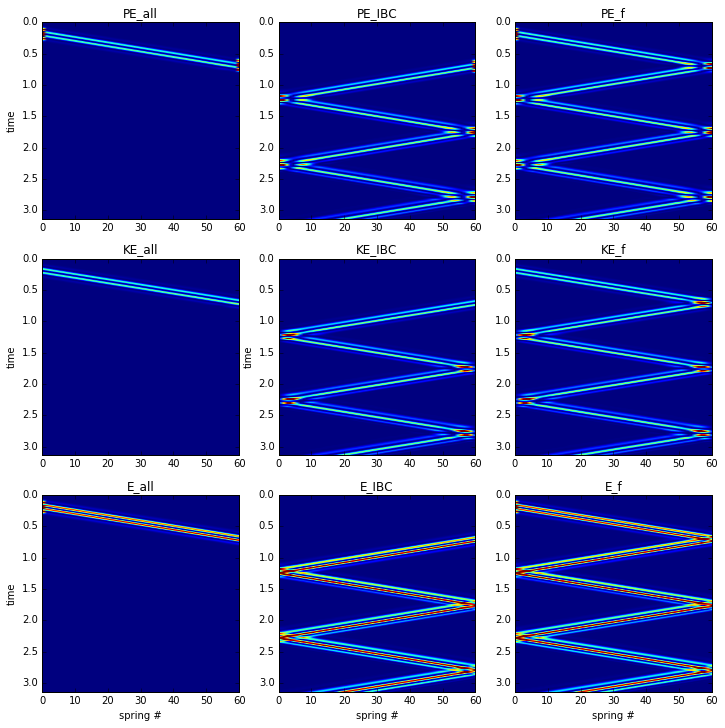

In [33]:
t_to_plot=700
clims=[0,1e-9]
plt.figure(figsize=[12,12])
plt.subplot(331)
plt.imshow(PE_all,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('PE_all')
plt.clim(clims)
plt.ylabel('time')
plt.subplot(332)
plt.imshow(PE_IBC,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('PE_IBC')
plt.clim(clims)
plt.subplot(333)
plt.imshow(PE_f,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('PE_f')
plt.clim(clims)
plt.subplot(334)
plt.imshow(KE_all,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('KE_all')
plt.clim(clims)
plt.ylabel('time')
plt.subplot(335)
plt.imshow(KE_IBC,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('KE_IBC')
plt.clim(clims)
plt.ylabel('time')
plt.subplot(336)
plt.imshow(KE_f,aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('KE_f')
plt.clim(clims)
plt.subplot(337)
plt.imshow(KE_all+PE_all[1:-1,:-1],aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('E_all')
plt.clim(clims)
plt.ylabel('time')
plt.xlabel('spring #')
plt.subplot(338)
plt.imshow(KE_IBC+PE_IBC[1:-1,:-1],aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('E_IBC')
plt.clim(clims)
plt.xlabel('spring #')
plt.subplot(339)
plt.imshow(KE_f+PE_f[1:-1,:-1],aspect='auto',extent=[0,nmasses2,t[nt-1],t[0]])
plt.title('E_f')
plt.clim(clims)
plt.xlabel('spring #')
plt.show()